In [41]:
import gzip

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
# helper functions to read the idx data

def dataset_images(file: str) -> np.ndarray:
    with gzip.open(file, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8)\
            .reshape((image_count, row_count, column_count))
        return images

def dataset_labels(file: str) -> np.ndarray:
    with gzip.open(file, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels

### Loading the dataset

In [43]:
# get image and label data from file
X = dataset_images('train-images-idx3-ubyte.gz')
y = dataset_labels('train-labels-idx1-ubyte.gz')

# loading testing set
X_test = dataset_images('t10k-images-idx3-ubyte.gz')
y_test = dataset_labels('t10k-labels-idx1-ubyte.gz')

### Splitting the dataset

Splitting the dataset into train, validate and test set.

The **training set** is used to fit our model. We train our model on the training set.

The **validation** set is used to fine tune our model.

The **test set** is used to evaluate the final performance of our model.

In [44]:
# since the dataset already has a testing set,
# I will splitting training set into training and validate set with 8:2 ratio  
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, shuffle=True)

7


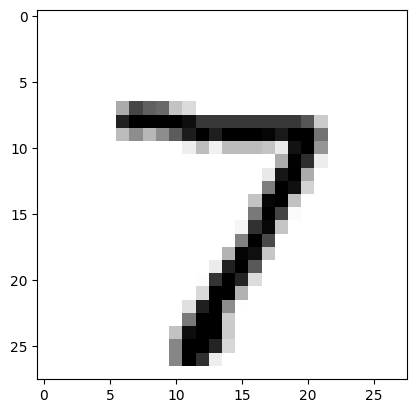

In [45]:
# checking image and label
plt.imshow(X_test[0], cmap=plt.cm.binary)
print(y_test[0])

In [46]:
# reshaping the array before fitting
X_train = X_train.reshape(-1, 28 * 28)
X_validate = X_validate.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

In [47]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

RandomForestClassifier()

In [48]:
# checking the score before pruning
best_score = forest.score(X_validate, y_validate)
print(f"Base score: {best_score}")

Base score: 0.9663333333333334


In [49]:
# get the setting of the current model
forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Tuning the model

To fine-tune the model, I will focus on adjusting the maximum depth of the trees and the number of trees in the ensemble, as these have the greatest impact on model performance. I will search for the optimal values within a reasonable range, also n_jobs is set to 12 to speed up the execution time.


In [50]:
# set up a reasonable range to check for best score
n_estimators = [1, 2, 4, 8, 16, 32] + [*range(40, 310, 10)]

validate_score = []

for n in n_estimators:
    # create model with given n_estimators
    forest = RandomForestClassifier(n_estimators=n, n_jobs=12)
    # fitting the model
    forest.fit(X_train, y_train)
    # saving the score
    validate_score.append(forest.score(X_validate, y_validate))
    


In [51]:
max_val = max(validate_score)
# get the number of trees according to the best score
idx = validate_score.index(max_val)
best_n_estimators = n_estimators[idx]
print(f"The best score {max_val} at n_estimators {best_n_estimators}")

The best score 0.9688333333333333 at n_estimators 220


In [52]:
# set a reasonable range
depths = [*range(1, 40)]

validate_score = []

for d in depths:
    # create model with given depth
    forest = RandomForestClassifier(max_depth=d ,n_estimators=280, n_jobs=12)
    # fitting the model
    forest.fit(X_train, y_train)
    # save the score
    validate_score.append(forest.score(X_validate, y_validate))
    

In [53]:
max_val = max(validate_score)
# get depth accordiing to the best score
idx = validate_score.index(max_val)
best_max_depth = depths[idx]
print(f"The best score {max_val} at depth {best_max_depth}")

The best score 0.9693333333333334 at depth 35


In [54]:
# max_depth = None
# num_estimators = 100
# jobs = 12

# # the following code took 74m and 40 sec to complete with 12 threads
# # Best score 0.969 at max depth 19 with number of estimators 135
# for d in range(1, 20 + 1):
#     for n in range(101, 200 + 1):
#         # setting up our model with given depth and num of trees with 12 threads
#         forest = RandomForestClassifier(max_depth=d, n_estimators=n, n_jobs=jobs)
#         # fitting the model with training set
#         forest.fit(X_train, y_train)
#         # get the score with validate set
#         score = forest.score(X_validate, y_validate)
#         # storage the variable according if we get a better score
#         if score > best_score:
#             best_score = score
#             max_depth = d
#             num_estimators = n
        
# print(f"Best score {best_score} at max depth {max_depth} with number of estimators {num_estimators}")

### Testing our model

Based on our results, the best score we obtained with maximum tree depth and number of trees. These parameters will be used to test the performance of the model on the test set.

In [55]:
# creating model
model = RandomForestClassifier(max_depth=best_max_depth, n_estimators=best_n_estimators, n_jobs=12)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=35, n_estimators=220, n_jobs=12)

In [60]:
# getting score data
print(f"Score on validate set as a base {model.score(X_validate, y_validate)}")

Score on validate set as a base 0.9675833333333334


### Confusion Matrix

According to the confusion matrix, our model struggles with digit **9** the most

<AxesSubplot: >

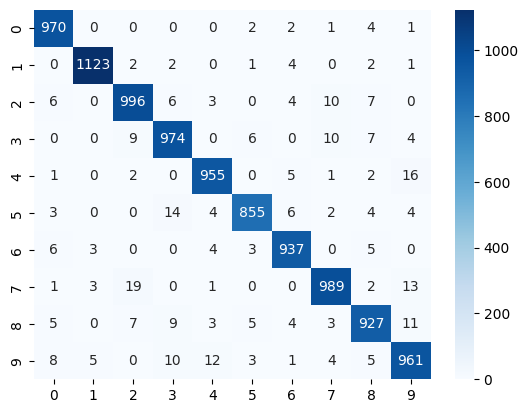

In [57]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

# getting the confusion matrix
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf_matrix = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(conf_matrix, columns=classes, index=classes)

sns.heatmap(cm_df, annot=True, 
            fmt='', cmap='Blues')

### Report

Reporting the accuracy, precision, recall, and f1-score of our model

In [59]:
print(f"Score on test set {model.score(X_test, y_test)}")

Score on test set 0.9687


The following is the detail report on the performance of our model

In [58]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.96      0.97       892
           6       0.97      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

